# Testing on XCAT Frames

This notebook will take you through the analysis performed on the raw XCAT PET frames. Qualitative comparisons will be made against images with and without motion. Additionally, for a variety of breathing extents, the predicted optical flows will be compared against the ground truth flows. Finally, the tumor recovery metrics will be calculated and compared in each image.

In [1]:
from flownet import FlowNetPET
from utils import create_normalize
from analysis_xcat import (plot_progress, load_phantoms, sample_output, apply_correction, 
                           evaluate_flows, calc_iou, plot_flow_pred, plot_orig_corr,
                           box_plot_flow_residuals, plot_metric_comparison_vert)

import configparser
import numpy as np
import torch
import os

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Using Torch version: %s' % (torch.__version__))
print('Using a %s device' % (device))

Using Torch version: 1.11.0+cu102
Using a cpu device


Load FlowNet-PET

In [2]:
# Name of saved model
model_name = 'fnp_1'

# Directories
cur_dir = ''
config_dir = os.path.join(cur_dir, 'configs/')
model_dir = os.path.join(cur_dir, 'models/')
progress_dir = os.path.join(cur_dir, 'progress/')
data_dir = os.path.join(cur_dir, 'data/')
    
# Model configuration
config = configparser.ConfigParser()
config.read(config_dir+model_name+'.ini')
architecture_config = config['ARCHITECTURE']
print('\nCreating model: %s'%model_name)

print('\nConfiguration:')
for key_head in config.keys():
    if key_head=='DEFAULT':
        continue
    print('  %s' % key_head)
    for key in config[key_head].keys():
        print('    %s: %s'%(key, config[key_head][key]))

# Construct Network
print('\nBuilding networks...')
model = FlowNetPET(architecture_config, device)
model.to(device)

print('\nLoading saved model...')
# Load model info
model_filename =  os.path.join(model_dir,model_name+'.pth.tar')
checkpoint = torch.load(model_filename, map_location=lambda storage, loc: storage)
losses = dict(checkpoint['losses'])

# Load model weights
model.load_state_dict(checkpoint['model'])

# Create normalization function for image frames
normalize = create_normalize(checkpoint['x_mean'], checkpoint['x_std'])


Creating model: fnp_1

Configuration:
  DATA
    data_file: xcat_training_set.h5
  TRAINING
    batchsize: 1
    learning_rate: 0.0003
    lr_decay_batch_iters: 8000
    lr_decay: 0.7
    total_batch_iters: 150000
    smooth_weight: 0.0
    res_weights: [1.0, 1.0, 1.0, 1.0]
    l2_weight: 0.0
    inv_weight: 1100.0
    photo_alpha: 0.3
  ARCHITECTURE
    input_shape: [108, 152, 152]
    gauss_kernel_len: 15
    gauss_sigma: 0.8
    conv_filts: [16, 32, 64]
    conv_filt_lens: [3, 3, 3]
    conv_strides: [2, 2, 2]
    latent_filters: 256
    interp_mode: bilinear
  Notes
    comment: Original architecture.

Building networks...


/arc/home/obriaint/.local/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


The flow predictions will have sizes:
108 x 152 x 152
54 x 76 x 76
27 x 38 x 38
14 x 19 x 19

Loading saved model...


Plot the training progress. Note that the comparisons witht the ground truth flows were only done on the validation set; this metric was not used for training.

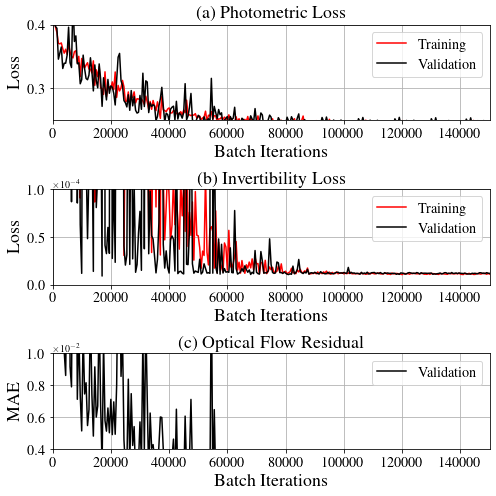

In [3]:
plot_progress(losses, y_lims=[(0.25,0.4),(0,1e-4),(4e-3,1e-2)], x_lim=(0,1.5e5),fontsize=18,
              savename='figures/fig12.pdf')

Perform the corrections on the entire test set and display the results.

Performing on a diaphragm extent of 9.0 mm...
Performing on a diaphragm extent of 12.0 mm...
Performing on a diaphragm extent of 15.0 mm...


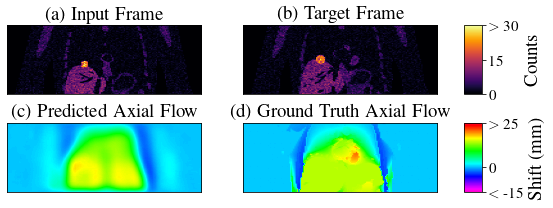

Performing on a diaphragm extent of 18.0 mm...
Performing on a diaphragm extent of 21.0 mm...


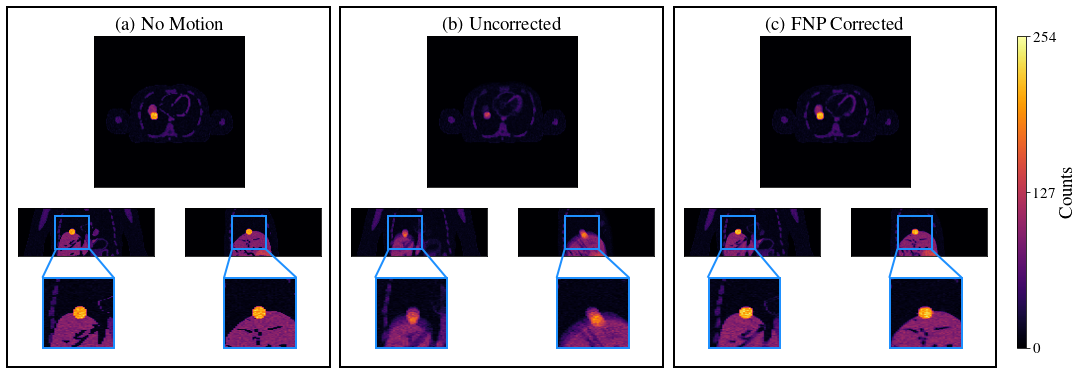

Finished.


In [4]:
h5_fn = os.path.join(data_dir, 'xcat_frames_test_set.h5')
pat_num = 1
avg_counts = 9e6
n_samples = int(1.2e6)
pixel_width = 4 # mm
slice_width = 2 # mm
AP_expansions = [0.6,0.8,1.0,1.2,1.4] # cm

tot_counts_gt = []
tot_counts_orig = []
tot_counts_corr = []
snr_gt = []
snr_orig = []
snr_corr = []
iou_gt = np.ones((len(AP_expansions),))
iou_orig = []
iou_corr = []
med_resids = []
max_flow_diffs = []

for AP_expansion in AP_expansions:
    print('Performing on a diaphragm extent of %0.1f mm...' % (15*AP_expansion))

    # Load images and flows
    tgt_img, inp_imgs, tumour_loc, gt_flows, gt_flow_masks  = load_phantoms(h5_fn, pat_num, 
                                                                            AP_expansion)

    # Create sample for ground truth
    gt_img = sample_output(tgt_img, int(n_samples*(len(inp_imgs)+1)))

    # Determine pixels including lesion
    tgt_lsn = (tgt_img==np.max(tgt_img)).astype(int)
    inp_lsn = (inp_imgs==np.max(tgt_img)).astype(int)
    gt_mask = np.copy(tgt_lsn)

    # Apply correction
    (orig_img, corr_img, pred_flows, orig_mask, 
     corr_mask, input_samples, target_sample) = apply_correction(model, inp_imgs, tgt_img, avg_counts, 
                                                                 n_samples, inp_lsn, tgt_lsn, device,
                                                                 normalize)

    # Calculate difference in flow predictions in mm
    flow_diffs = evaluate_flows(gt_img, pred_flows, gt_flows, gt_flow_masks, pixel_width, slice_width)

    # Select the flow with the largest true flow to compare
    max_flow_index = np.argmax(np.sum(np.abs(gt_flows), axis=(1,2,3,4)))

    flow_diff = np.copy(flow_diffs[max_flow_index])
    max_flow_diffs.append(flow_diff)
    med_resid = np.median(flow_diff) 
    med_resids.append(med_resid)

    tot_counts_gt.append(np.sum(gt_img[gt_mask.astype(bool)]))
    tot_counts_orig.append(np.sum(orig_img[gt_mask.astype(bool)]))
    tot_counts_corr.append(np.sum(corr_img[gt_mask.astype(bool)]))

    snr_gt.append(np.mean(gt_img[gt_mask.astype(bool)])/np.std(gt_img[gt_mask.astype(bool)]))
    snr_orig.append(np.mean(orig_img[gt_mask.astype(bool)])/np.std(orig_img[gt_mask.astype(bool)]))
    snr_corr.append(np.mean(corr_img[gt_mask.astype(bool)])/np.std(corr_img[gt_mask.astype(bool)]))

    iou_orig.append(calc_iou(gt_mask, orig_mask))
    iou_corr.append(calc_iou(gt_mask, corr_mask))
    
    if AP_expansion==1.:
        plot_flow_pred(input_samples[max_flow_index], target_sample, 
               pred_flows[max_flow_index], gt_flows[max_flow_index], 
               fontsize=19, vmax_frac=.8, flow_min=-15, flow_max=25, 
               centre=tumour_loc, spacing=np.array([2, 4, 4]),
               show=True, savename='figures/fig3.pdf')
    
    if AP_expansion==1.4:
        plot_orig_corr(gt_img, orig_img, corr_img,
                     vmax_frac=1,
                     fontsize=19, centre=tumour_loc, lesn_diameter=25,
                     show=True, savename='figures/fig5.pdf')
print('Finished.')

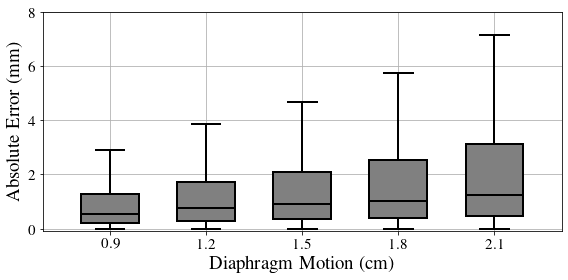

In [5]:
box_plot_flow_residuals(np.round(np.array(AP_expansions)*1.5,1), max_flow_diffs, 
                        y_lims=(-0.1,8), fontsize=19, x_label='Diaphragm Motion (cm)', 
                        savename='figures/fig4.pdf')

Residual Imporvements:
IOU:  [61. 61. 64. 59. 63.]
IOU (avg):  62.0
Counts:  [81. 91. 88. 91. 92.]
Counts (avg):  89.0
COV:  [70. 81. 73. 70. 76.]
COV (avg):  74.0


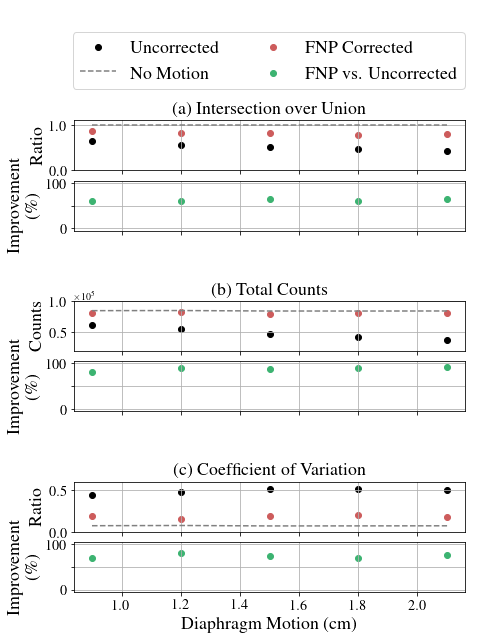

In [6]:
plot_metric_comparison_vert(np.array(AP_expansions)*1.5, tot_counts_gt, 
                           tot_counts_orig, tot_counts_corr, 
                           snr_gt, snr_orig, snr_corr, 
                           iou_orig, iou_corr,
                           y_lims=[(0,1.1),(2e4,1e5),(0,0.6)], fontsize=18, cov=True,
                           x_label='Diaphragm Motion (cm)', 
                            savename='figures/fig6.pdf')